In [1]:
import torch
import random
import numpy as np
%matplotlib inline
from IPython import display

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=False, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=False, train=False)

In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

E:\anaconda1\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
E:\anaconda1\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
E:\anaconda1\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
E:\anaconda1\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [5]:
X_train = X_train.float()
X_test = X_test.float()

In [6]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [7]:
X_train.reshape(len(X_train[1]), len(X_train), len(X_train[2])).shape

torch.Size([28, 60000, 28])

In [8]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

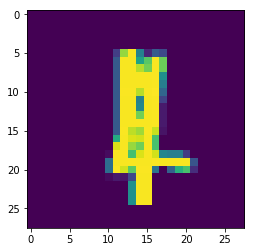

tensor(4)


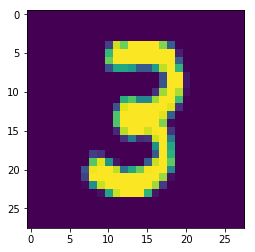

tensor(3)


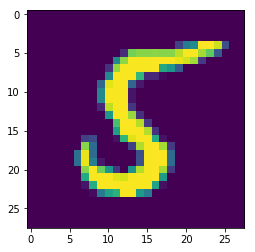

tensor(5)


In [9]:
import matplotlib.pyplot as plt
z = random.randint(0, 60000)
for i in range(z, z+3):
    plt.imshow(X_train[i, :, :])
    plt.show()
    print(y_train[i])

In [10]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [11]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.activ1 = torch.nn.LeakyReLU(inplace = True)
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.BatchNorm1d(n_hidden_neurons)
        self.fc3 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ3 = torch.nn.Dropout(p = 0.6)
        self.fc4 = torch.nn.Linear(n_hidden_neurons, 10)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        x = self.activ3(x)
        x = self.fc4(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
mnist_net = MNISTNet(40)

In [12]:
torch.cuda.is_available()

False

In [13]:
#!nvidia-smi

In [14]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# mnist_net = mnist_net.to(device)
# list(mnist_net.parameters())

In [15]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=3.0e-4)

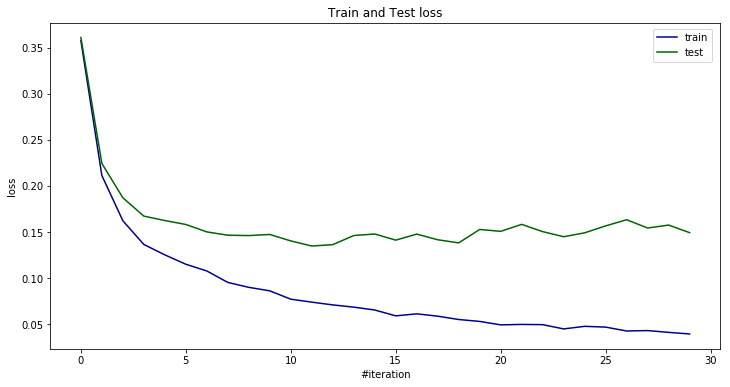

In [16]:
import numpy as np 

batch_size = 100
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

#X_test = X_test.to(device)
#y_test = y_test.to(device)
#
#X_train = X_train.to(device)
#y_train = y_train.to(device)

for epoch in range(30):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]#.to(device)
        y_batch = y_train[batch_indexes]#.to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))

    train_preds = mnist_net.forward(X_train)
    train_loss_history.append(loss(train_preds, y_train))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    
    display.clear_output(wait=True)
    plt.figure(figsize=(12, 6))        
    plt.title("Train and Test loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_loss_history, 'b', color = 'darkblue', label="train")
    plt.plot(test_loss_history, 'b', color = 'darkgreen', label="test")
    plt.legend(bbox_to_anchor=(0.9, 0.88), loc=3, borderaxespad=0.)
    plt.show()

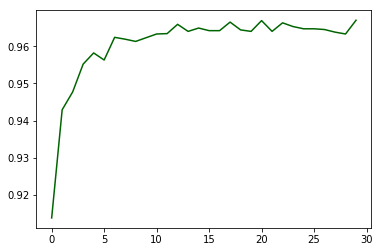

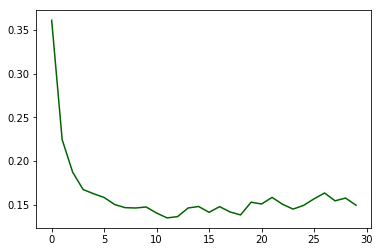

In [17]:
plt.plot(test_accuracy_history, 'b', color = 'darkgreen')
plt.show()
plt.plot(test_loss_history, 'b', color = 'darkgreen')
plt.show()

In [18]:
test_preds = mnist_net.inference(X_test)
(test_preds.argmax(dim=1) == y_test).float().mean()

tensor(0.9668)